### Water surface elevation(wse) extraction from the SWOT LakeSP data.


#### 1. Extract wse variable from the SWOT LakeSP data.

In [1]:
import warnings
import pickle 
import rasterio as rio
warnings.filterwarnings("ignore")
import geopandas as gpd
from glob import glob
import numpy as np
import cartopy.crs as ccrs
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from utils.add_north_arrow import add_north_arrow
from utils.add_scale_bar import add_scale_bar
from utils.date_transform import date_to_decimal, decimal_to_date


In [2]:
plt.rcParams['font.family'] = 'Microsoft YaHei'


In [3]:
lake_name = 'erhai'
dir_lakeSP = 'data/swot_l2/lakeSP/'+lake_name+'-lake'


Unzip the lakeSP file.

In [4]:
# zip_files = glob(dir_lakeSP + '/*.zip')
# for file in zip_files:
#     with zipfile.ZipFile(file, 'r') as zip_ref:
#         zip_ref.extractall(file.split('.')[0])


Extract wse variable from the LakeSP data.

In [5]:
unzipped_files = sorted(glob(dir_lakeSP + '/*/*.shp'))
unzipped_files[0]


'data/swot_l2/lakeSP/erhai-lake/SWOT_L2_HR_LakeSP_Prior_001_424_AS_20230805T082825_20230805T084112_PGC0_01/SWOT_L2_HR_LakeSP_Prior_001_424_AS_20230805T082825_20230805T084112_PGC0_01.shp'

In [6]:
lake_wse = {'date': [], 'wse': [], 'geometry':[]}  ## dictionary to store lake level data
if lake_name == 'dianchi': lakesp_name = 'DIAN CHI'   ## 'DIAN CHI'
elif lake_name == 'erhai': lakesp_name = 'ERH;ER HAI'   ## 'ERH;ER HAI'
for file in unzipped_files:
    file_gpd = gpd.read_file(file)
    ids = np.where((file_gpd['lake_name']==lakesp_name) & 
                   (file_gpd['wse_std'] > 0) &                  
                   (file_gpd['wse_std'] < 0.8) &   
                   (file_gpd['wse_u'] < 0.2) &   
                   (file_gpd['area_total'] > 1) & 
                   (file_gpd['geometry'].notnull()))[0]     
    if len(ids) == 0:
        # print(f"No data for lake in file")
        continue
    else:
        lake = file_gpd.loc[ids]  # there is only one lake in the shapefile
        date_decimal = date_to_decimal(lake.iloc[0]['time_str'][:-1])
        date_decimal = round(date_decimal, 5)        
        wse_mean = np.round(lake['wse'].mean(), 4)
        geom = lake['geometry'].unary_union
        lake_wse['date'].append(date_decimal)
        lake_wse['geometry'].append(geom)
        lake_wse['wse'].append(wse_mean)
print(len(lake_wse['wse']))


17


In [7]:
lake_wse_gpd = gpd.GeoDataFrame(lake_wse, geometry='geometry', crs='EPSG:4326')
print(lake_wse_gpd.shape)  
lake_wse_gpd.head()  


(17, 3)


,date,wse,geometry
0,2023.84464,1966.471,"MULTIPOLYGON (((100.22629 25.56987, 100.22604 ..."
1,2023.90180,1966.434,"MULTIPOLYGON (((100.15912 25.71065, 100.15893 ..."
2,2023.90180,1966.438,"MULTIPOLYGON (((100.15912 25.71065, 100.15894 ..."
3,2023.95897,1966.386,"MULTIPOLYGON (((100.21552 25.57651, 100.21529 ..."
4,2023.95897,1966.371,"MULTIPOLYGON (((100.21547 25.57652, 100.21525 ..."


In [ ]:
# Save to vector file
path_save = dir_lakeSP+'/'+lake_name+'_wse_lakesp.gpkg'
lake_wse_gpd.to_file(path_save, driver='GPKG')

### save to pkl data 
lake_wse_dict = dict(zip(lake_wse['date'], lake_wse['wse']))
path_save = dir_lakeSP+'/'+lake_name+'_wse_lakesp.pkl'
with open(path_save, 'wb') as f:
       pickle.dump(lake_wse_dict, f)


#### 2. Check lakesp data

In [31]:
path_dianchi_vec = 'data/lakes-vec/dianchi_s2_20240415.gpkg'
path_erhai_vec = 'data/lakes-vec/erhai_s2_20240801.gpkg'
path_dianchi = 'data/swot_l2/lakeSP/dianchi-lake/dianchi_wse_lakesp.gpkg'
path_erhai = 'data/swot_l2/lakeSP/erhai-lake/erhai_wse_lakesp.gpkg'
dianchi_wse_gpd = gpd.read_file(path_dianchi)
erhai_wse_gpd = gpd.read_file(path_erhai)
dianchi_vec_gpd = gpd.read_file(path_dianchi_vec)
erhai_vec_gpd = gpd.read_file(path_erhai_vec)


In [32]:
path_dianchi_img = 'data/rsimg/dianchi_s2_20240415_wgs84.tif'
path_erhai_img = 'data/rsimg/erhai_s2_20240801_wgs84.tif'
src_dianchi_img = rio.open(path_dianchi_img)
src_erhai_img = rio.open(path_erhai_img)


Text(0.5, 1.0, 'Erhai Lake WSE on 2023-11-26T03:46:04')

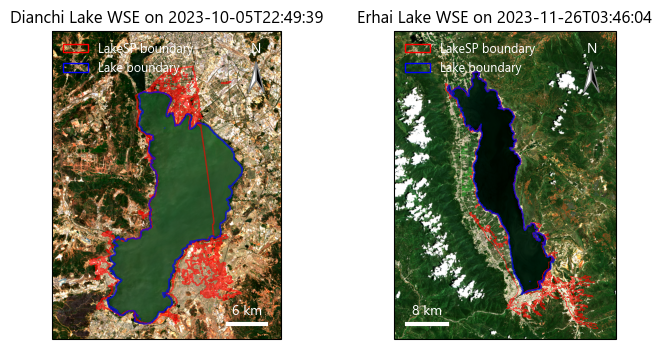

In [49]:
proj_wgs84 = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection': proj_wgs84})
### ax[0]: Dianchi
id_dianchi = 4; dianchi_date = dianchi_wse_gpd.iloc[id_dianchi:id_dianchi+1]
### legends
legend_elements = [Patch(facecolor='none', edgecolor='red', label='LakeSP boundary'), 
                   Patch(facecolor='none', edgecolor='blue', label='Lake boundary')]  #
ax[0].set_extent([102.52, 102.84, 24.65, 25.04], crs=proj_wgs84)
show(src_dianchi_img, percent_range=[5, 95], indexes=[3,2,1], ax=ax[0], transform=proj_wgs84)
dianchi_date.plot(ax=ax[0], color='none',  edgecolor='red', linewidth=1, label='dianchi WSE', alpha=0.6)
dianchi_vec_gpd.plot(ax=ax[0], color='none', edgecolor='blue', linewidth=1, label='Dianchi Lake Boundary', alpha=0.6)
add_north_arrow(ax[0], loc=(0.89, 0.85), size=[0.07, 0.05], font_N=10, color_N='white')
add_scale_bar(ax[0], loc=(0.85, 0.05), length=6, color_bar='white', color_text='white')
ax[0].legend(handles=legend_elements, 
             loc='upper left',
             labelcolor='white', 
             fontsize=9, 
             frameon=False, 
             markerscale=2.5)
ax[0].set_title(f'Dianchi Lake WSE on {decimal_to_date(dianchi_date["date"].values[0])}')

### ax[1]: Erhai
id_erhai = 2; erhai_date = erhai_wse_gpd.iloc[id_erhai:id_erhai+1]
ax[1].set_extent([100, 100.4, 25.53, 26.03], crs=proj_wgs84)
show(src_erhai_img, percent_range=[5, 95], indexes=[3,2,1], ax=ax[1], transform=proj_wgs84)
erhai_date.plot(ax=ax[1], color='none',  edgecolor='red', linewidth=0.5, label='Erhai WSE', alpha=0.6)
erhai_vec_gpd.plot(ax=ax[1], color='none', edgecolor='blue', linewidth=1, 
                   legend=True,  #
                   label='Erhai Lake Boundary', alpha=0.6)
add_north_arrow(ax[1], loc=(0.89, 0.85), size=[0.07,0.05], color_N='white', font_N=10)
add_scale_bar(ax[1], loc=(0.15, 0.05), length=8, color_bar='white', color_text='white')
ax[1].legend(handles=legend_elements, 
             loc='upper left', 
             labelcolor='white',
             fontsize=9, 
             frameon=False, 
             markerscale=2.5,
             )
ax[1].set_title(f'Erhai Lake WSE on {decimal_to_date(erhai_date["date"].values[0])}')


Delete the unzipped folder.

In [ ]:
# import os
# import shutil
# unzipped_dir = [file for file in glob(dir_lakeSP + '/*') if not file.endswith('.zip')]
# unzipped_dir
# for folder in unzipped_dir:
#     if os.path.isdir(folder):
#         shutil.rmtree(folder)
